# Initialization

## Import

In [17]:
import torch
import math
import torch.nn as nn

In [ ]:
!pip install easydict

## Progress Bar

In [19]:
import sys
import time

TOTAL_BAR_LENGTH = 80
LAST_T = time.time()
BEGIN_T = LAST_T


def progress_bar(current, total, msg=None):
    global LAST_T, BEGIN_T
    if current == 0:
        BEGIN_T = time.time()  # Reset for new bar.

    current_len = int(TOTAL_BAR_LENGTH * (current + 1) / total)
    rest_len = int(TOTAL_BAR_LENGTH - current_len) - 1

    sys.stdout.write(' %d/%d' % (current + 1, total))
    sys.stdout.write(' [')
    for i in range(current_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    current_time = time.time()
    step_time = current_time - LAST_T
    LAST_T = current_time
    total_time = current_time - BEGIN_T

    time_used = '  Step: %s' % format_time(step_time)
    time_used += ' | Tot: %s' % format_time(total_time)
    if msg:
        time_used += ' | ' + msg

    msg = time_used
    sys.stdout.write(msg)

    if current < total - 1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()


# return the formatted time
def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    seconds_final = int(seconds)
    seconds = seconds - seconds_final
    millis = int(seconds*1000)

    output = ''
    time_index = 1
    if days > 0:
        output += str(days) + 'D'
        time_index += 1
    if hours > 0 and time_index <= 2:
        output += str(hours) + 'h'
        time_index += 1
    if minutes > 0 and time_index <= 2:
        output += str(minutes) + 'm'
        time_index += 1
    if seconds_final > 0 and time_index <= 2:
        output += str(seconds_final) + 's'
        time_index += 1
    if millis > 0 and time_index <= 2:
        output += str(millis) + 'ms'
        time_index += 1
    if output == '':
        output = '0ms'
    return output

## Data Loader

In [20]:
from os import listdir
from os.path import join

import torch.utils.data as data
from PIL import Image


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])


def load_img(filepath):
    img = Image.open(filepath).convert('YCbCr')
    y, _, _ = img.split()
    return y


class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, input_transform=None, target_transform=None):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]

        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        input_image = load_img(self.image_filenames[index])
        target = input_image.copy()
        if self.input_transform:
            input_image = self.input_transform(input_image)
        if self.target_transform:
            target = self.target_transform(target)

        return input_image, target

    def __len__(self):
        return len(self.image_filenames)

In [21]:
import os
import tarfile
from os import remove
from os.path import exists, join, basename

from six.moves import urllib
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize

def download_bsd300(dest="/content/dataset"):
    output_image_dir = join(dest, "BSDS300/images")

    if not exists(output_image_dir):
        url = "http://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
        print("downloading url ", url)

        os.makedirs(os.path.dirname(output_image_dir), exist_ok=True)

        data = urllib.request.urlopen(url)

        file_path = join(dest, basename(url))
        with open(file_path, 'wb') as f:
            f.write(data.read())

        print("Extracting data")
        with tarfile.open(file_path) as tar:
            for item in tar:
                tar.extract(item, dest)

        remove(file_path)

    return output_image_dir


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def input_transform(crop_size, upscale_factor):
    return Compose([
        CenterCrop(crop_size),
        Resize(crop_size // upscale_factor),
        ToTensor(),
    ])


def target_transform(crop_size):
    return Compose([
        CenterCrop(crop_size),
        ToTensor(),
    ])


def get_training_set(upscale_factor):
    root_dir = download_bsd300()
    train_dir = join(root_dir, "train")
    crop_size = calculate_valid_crop_size(256, upscale_factor)

    return DatasetFromFolder(train_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))


def get_test_set(upscale_factor):
    root_dir = download_bsd300()
    test_dir = join(root_dir, "test")
    crop_size = calculate_valid_crop_size(256, upscale_factor)

    return DatasetFromFolder(test_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))

## SSIM func

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

def calculate_ssim(tensor1, tensor2):
    ssim_values = []
    for i in range(tensor1.size(0)):  # Iterate over the batch
        img1 = tensor1[i].cpu().detach().numpy().squeeze()  # Convert to numpy and remove channel dimension
        img2 = tensor2[i].cpu().detach().numpy().squeeze()  # Same for the second tensor

        # Calculate SSIM, assuming the images are grayscale so channel_axis is None
        ssim_value = ssim(img1, img2, data_range=img1.max() - img1.min())
        ssim_values.append(ssim_value)

    return np.mean(ssim_value)

# Models

## SRCNN Model

In [22]:
class Net915(torch.nn.Module):
    def __init__(self, num_channels, base_filter, upscale_factor=2):
        super(Net915, self).__init__()

        self.layers = torch.nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=base_filter, kernel_size=9, stride=1, padding=4, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=base_filter, out_channels=base_filter // 2, kernel_size=1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=base_filter // 2, out_channels=num_channels * (upscale_factor ** 2), kernel_size=5, stride=1, padding=2, bias=True),
            nn.PixelShuffle(upscale_factor)
        )

    def forward(self, x):
        out = self.layers(x)
        return out

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)


def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [23]:
class Net935(torch.nn.Module):
    def __init__(self, num_channels, base_filter, upscale_factor=2):
        super(Net935, self).__init__()

        self.layers = torch.nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=base_filter, kernel_size=9, stride=1, padding=4, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=base_filter, out_channels=base_filter // 2, kernel_size=3, padding=1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=base_filter // 2, out_channels=num_channels * (upscale_factor ** 2), kernel_size=5, stride=1, padding=2, bias=True),
            nn.PixelShuffle(upscale_factor)
        )

    def forward(self, x):
        out = self.layers(x)
        return out

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

In [24]:
class Net955(torch.nn.Module):
    def __init__(self, num_channels, base_filter, upscale_factor=2):
        super(Net955, self).__init__()

        self.layers = torch.nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=base_filter, kernel_size=9, stride=1, padding=4, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=base_filter, out_channels=base_filter // 2, kernel_size=5, padding=2, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=base_filter // 2, out_channels=num_channels * (upscale_factor ** 2), kernel_size=5, stride=1, padding=2, bias=True),
            nn.PixelShuffle(upscale_factor)
        )

    def forward(self, x):
        out = self.layers(x)
        return out

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

## FSRCNN Model

In [25]:
import torch
import torch.nn as nn


class FNet(torch.nn.Module):
    def __init__(self, num_channels, upscale_factor, d=64, s=12, m=4):
        super(FNet, self).__init__()

        self.first_part = nn.Sequential(nn.Conv2d(in_channels=num_channels, out_channels=d, kernel_size=5, stride=1, padding=2),
                                        nn.PReLU())

        self.layers = []
        self.layers.append(nn.Sequential(nn.Conv2d(in_channels=d, out_channels=s, kernel_size=1, stride=1, padding=0),
                                         nn.PReLU()))
        for _ in range(m): # EXP
            self.layers.append(nn.Conv2d(in_channels=s, out_channels=s, kernel_size=3, stride=1, padding=1))
        self.layers.append(nn.PReLU())
        self.layers.append(nn.Sequential(nn.Conv2d(in_channels=s, out_channels=d, kernel_size=1, stride=1, padding=0),
                                         nn.PReLU()))
        self.mid_part = torch.nn.Sequential(*self.layers)
        # Deconvolution
        self.last_part = nn.ConvTranspose2d(in_channels=d, out_channels=num_channels, kernel_size=9, stride=upscale_factor, padding=int((10-upscale_factor)//2), output_padding=1)


    def forward(self, x):
        out = self.first_part(x)
        out = self.mid_part(out)
        out = self.last_part(out)
        return out

    def weight_init(self, mean=0.0, std=0.02):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(mean, std)
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0.0, 0.0001)
                if m.bias is not None:
                    m.bias.data.zero_()

In [ ]:
!pip install progressbar2

# Trainer

## SRCNN Solver

In [27]:
from __future__ import print_function

from math import log10

import torch
import torch.backends.cudnn as cudnn
from torch.autograd import profiler

class SRCNNTrainer(object):
    def __init__(self, config, training_loader, testing_loader):
        super(SRCNNTrainer, self).__init__()
        self.CUDA = torch.cuda.is_available()
        self.device = torch.device('cuda' if self.CUDA else 'cpu')
        self.model = None
        self.lr = config.lr
        self.nEpochs = config.nEpochs
        self.criterion = None
        self.optimizer = None
        self.scheduler = None
        self.seed = config.seed
        self.upscale_factor = config.upscale_factor
        self.training_loader = training_loader
        self.testing_loader = testing_loader
        self.dataForImage = []
        self.psnrForImage = []
        self.ssimForImage = []

    def build_model(self,modelName):# SRCNNMODELS = ["9-5-5","9-3-5","9-1-5"]
        if modelName == "9-5-5":
          self.model = Net955(num_channels=1, base_filter=64, upscale_factor=self.upscale_factor).to(self.device)
        elif modelName == "9-3-5":
          self.model = Net935(num_channels=1, base_filter=64, upscale_factor=self.upscale_factor).to(self.device)
        else:
          self.model = Net915(num_channels=1, base_filter=64, upscale_factor=self.upscale_factor).to(self.device)

        self.model.weight_init(mean=0.0, std=0.01)
        self.criterion = torch.nn.MSELoss()
        torch.manual_seed(self.seed)

        if self.CUDA:
            torch.cuda.manual_seed(self.seed)
            cudnn.benchmark = True
            self.criterion.cuda()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[50, 75, 100], gamma=0.5)

    def save_model(self):
        model_out_path = "model_path.pth"
        torch.save(self.model, model_out_path)
        print("Checkpoint saved to {}".format(model_out_path))

    def train(self):
        self.model.train()
        train_loss = 0
        with profiler.profile() as prof:
          for batch_num, (data, target) in enumerate(self.training_loader):
              data, target = data.to(self.device), target.to(self.device)
              self.optimizer.zero_grad()
              loss = self.criterion(self.model(data), target)
              train_loss += loss.item()
              loss.backward()
              self.optimizer.step()
              progress_bar(batch_num, len(self.training_loader), 'Loss: %.4f' % (train_loss / (batch_num + 1)))

        print(prof.key_averages().table(sort_by="cuda_time_total" if self.CUDA else "cpu_time_total"))
        print("    Average Loss: {:.4f}".format(train_loss / len(self.training_loader)))
        self.dataForImage.append(train_loss / len(self.training_loader))

    def test(self):
        self.model.eval()
        avg_psnr = 0
        avg_ssim = 0

        with torch.no_grad():
            for batch_num, (data, target) in enumerate(self.testing_loader):
                data, target = data.to(self.device), target.to(self.device)
                prediction = self.model(data)
                mse = self.criterion(prediction, target)
                psnr = 10 * log10(1 / mse.item())
                ssim = calculate_ssim(target, prediction)
                avg_psnr += psnr
                avg_ssim += ssim
                progress_bar(batch_num, len(self.testing_loader), 'PSNR: %.4f' % (avg_psnr / (batch_num + 1)))

        print("    Average PSNR: {:.4f} dB".format(avg_psnr / len(self.testing_loader)))
        self.psnrForImage.append(avg_psnr / len(self.testing_loader))
        self.ssimForImage.append(avg_ssim / len(self.testing_loader))


    def run(self,modelname):
        print("=======>Now running", modelname)
        self.build_model(modelname)
        for epoch in range(1, self.nEpochs + 1):
            print("\n===> Epoch {} starts:".format(epoch))
            self.train()
            self.test()
            self.scheduler.step(epoch)
            if epoch == self.nEpochs:
                self.save_model()

## FSRCNN Solver

In [28]:
from __future__ import print_function
from math import log10

import torch
import torch.backends.cudnn as cudnn



class FSRCNNTrainer(object):
    def __init__(self, config, training_loader, testing_loader):
        super(FSRCNNTrainer, self).__init__()
        self.CUDA = torch.cuda.is_available()
        self.device = torch.device('cuda' if self.CUDA else 'cpu')
        self.model = None
        self.lr = config.lr
        self.nEpochs = config.nEpochs
        self.criterion = None
        self.optimizer = None
        self.scheduler = None
        self.seed = config.seed
        self.upscale_factor = config.upscale_factor
        self.training_loader = training_loader
        self.testing_loader = testing_loader
        self.dataForImage = []
        self.psnrForImage = []
        self.ssimForImage = []

    def build_model(self,n):
        self.model = FNet(num_channels=1, upscale_factor=self.upscale_factor,m = n).to(self.device)
        self.model.weight_init(mean=0.0, std=0.2)
        self.criterion = torch.nn.MSELoss()
        torch.manual_seed(self.seed)

        if self.CUDA:
            torch.cuda.manual_seed(self.seed)
            cudnn.benchmark = True
            self.criterion.cuda()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[50, 75, 100], gamma=0.5)  # lr decay

    def save_model(self):
        model_out_path = "model_path.pth"
        torch.save(self.model, model_out_path)
        print("Checkpoint saved to {}".format(model_out_path))

    def train(self):
        self.model.train()
        train_loss = 0
        for batch_num, (data, target) in enumerate(self.training_loader):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            loss = self.criterion(self.model(data), target)
            train_loss += loss.item()

            loss.backward()
            self.optimizer.step()
            progress_bar(batch_num, len(self.training_loader), 'Loss: %.4f' % (train_loss / (batch_num + 1)))

        print("    Average Loss: {:.4f}".format(train_loss / len(self.training_loader)))
        self.dataForImage.append(train_loss / len(self.training_loader))
    def train_data():
      return self.dataForImage, self.psnrForImage



    def test(self):
        self.model.eval()
        avg_psnr = 0
        avg_ssim = 0

        with torch.no_grad():
            for batch_num, (data, target) in enumerate(self.testing_loader):
                data, target = data.to(self.device), target.to(self.device)
                prediction = self.model(data)
                mse = self.criterion(prediction, target)
                ssim = calculate_ssim(target, prediction)
                psnr = 10 * log10(1 / mse.item())
                avg_psnr += psnr
                avg_ssim += ssim
                progress_bar(batch_num, len(self.testing_loader), 'PSNR: %.4f' % (avg_psnr / (batch_num + 1)))

        print("    Average PSNR: {:.4f} dB".format(avg_psnr / len(self.testing_loader)))
        self.psnrForImage.append(avg_psnr / len(self.testing_loader))
        self.ssimForImage.append(avg_ssim / len(self.testing_loader))

    def run(self, m):
        self.build_model(m)
        for epoch in range(1, self.nEpochs + 1):
            print("\n===> Epoch {} starts:".format(epoch))
            self.train()
            self.test()
            self.scheduler.step(epoch)
            if epoch == self.nEpochs:
                self.save_model()

# Runner

In [30]:
from __future__ import print_function

from torch.utils.data import DataLoader

import torch.nn.functional as F

class Config:
    def __init__(self):
        self.batchSize = 4
        self.testBatchSize = 1
        self.nEpochs = 1
        self.lr = 0.001
        self.seed = 123
        self.upscale_factor = 8


    def __str__(self):
        return '\n'.join(f'{k} = {v}' for k, v in self.__dict__.items())
    def changeConfig(self,batchSize,nEpochs,lr,upscale_factor):
        self.batchSize = batchSize
        self.nEpochs = nEpochs
        self.lr = lr
        self.upscale_factor = upscale_factor

config = Config()

def bicubic_method(train_data_loader, testing_data_loader, scale_factor):
    avg_train_psnr = 0.0
    avg_train_ssim = 0.0
    avg_train_loss = 0.0
    mse_loss_fn = torch.nn.MSELoss()
    for batch_num, (data, target) in enumerate(train_data_loader):
        bicubic_result = F.interpolate(data, scale_factor=scale_factor, mode='bicubic', align_corners=False)
        avg_train_psnr += psnr(target.cpu().detach().numpy(), bicubic_result.cpu().detach().numpy())
        avg_train_ssim += calculate_ssim(target, bicubic_result)
        avg_train_loss += mse_loss_fn(target, bicubic_result)
    avg_train_psnr /= (batch_num+1)
    avg_train_ssim /= (batch_num+1)
    avg_train_loss /= (batch_num+1)
    avg_test_psnr = 0.0
    avg_test_ssim = 0.0
    avg_test_loss = 0.0
    for batch_num, (data, target) in enumerate(testing_data_loader):
        bicubic_result = F.interpolate(data, scale_factor=scale_factor, mode='bicubic', align_corners=False)
        avg_test_psnr += psnr(target.cpu().detach().numpy(), bicubic_result.cpu().detach().numpy())
        avg_test_ssim += calculate_ssim(target, bicubic_result)
        avg_test_loss += mse_loss_fn(target, bicubic_result)
    avg_test_psnr /= (batch_num+1)
    avg_test_ssim /= (batch_num+1)
    avg_test_loss /= (batch_num+1)
    print(f'Bicubic Method Baseline: {avg_train_psnr=}, {avg_test_psnr=}, {avg_train_ssim=}, {avg_test_ssim}')

    return avg_test_loss, avg_test_psnr, avg_test_ssim



## Compare number of parameters

In [39]:
# batchSize = [4, 16, 32]
# upscale = [2,3,4]
# lr = [0.01, 0.001, 0.0001]
#def MainRunner(config):

config.changeConfig(4, 1, 0.001, 4)#batchSize,nEpochs,lr,upscale_factor

print('===> Loading datasets')
train_set = get_training_set(config.upscale_factor)
test_set = get_test_set(config.upscale_factor)
training_data_loader = DataLoader(dataset=train_set, batch_size=config.batchSize, shuffle=True)
testing_data_loader = DataLoader(dataset=test_set, batch_size=config.testBatchSize, shuffle=False)

print('===> model base line')
bicubic_method(training_data_loader, testing_data_loader, config.upscale_factor)

print('===> model SRCNN')
modelSRCNN915 = SRCNNTrainer(config, training_data_loader, testing_data_loader)
modelSRCNN915.run("9-1-5")# SRCNNMODELS = ["9-5-5","9-3-5","9-1-5"]

modelSRCNN935 = SRCNNTrainer(config, training_data_loader, testing_data_loader)
modelSRCNN935.run("9-3-5")# SRCNNMODELS = ["9-5-5","9-3-5","9-1-5"]

modelSRCNN955 = SRCNNTrainer(config, training_data_loader, testing_data_loader)
modelSRCNN955.run("9-5-5")# SRCNNMODELS = ["9-5-5","9-3-5","9-1-5"]

print('===> model FSRCNN')
modelFSRCNN = FSRCNNTrainer(config, training_data_loader, testing_data_loader)
modelFSRCNN.run(3)


===> Loading datasets
===> model base line
Bicubic Method Baseline: avg_train_psnr=23.309264356572243, avg_test_psnr=23.65080925997721, avg_train_ssim=0.6157976619583244, 0.615720365176138
===> model SRCNN
=======>Now running 9-1-5

===> Epoch 1 starts:
 50/50 [================================================================================>]  Step: 10ms | Tot: 552ms | Loss: 0.0401
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         0.16%     853.000us         0.16%     853.000us       2.080us           410  
                                          aten:

c:\Users\Snowball\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


 50/50 [================================================================================>]  Step: 11ms | Tot: 539ms | Loss: 0.0347
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         0.18%     887.000us         0.18%     887.000us       2.163us           410  
                                          aten::random_         0.00%       7.000us         0.00%       7.000us       3.500us             2  
                                             aten::item         0.06%     312.000us         0.94%       4.763ms       7.305us           652  
                 

In [40]:
total_params915 = sum(p.numel() for p in modelSRCNN915.model.parameters() if p.requires_grad)
total_params935 = sum(p.numel() for p in modelSRCNN935.model.parameters() if p.requires_grad)
total_params955 = sum(p.numel() for p in modelSRCNN955.model.parameters() if p.requires_grad)
total_paramsfsr = sum(p.numel() for p in modelFSRCNN.model.parameters() if p.requires_grad)

print(total_params915)
print(total_params935)
print(total_params955)
print(total_paramsfsr)

20144
36528
69296
12389


### Plot image code

In [32]:
import matplotlib.pyplot as plt

def plotter(DATA1,MODEL,imgtitle, metric):

  x = range(len(DATA1[MODEL[0]]))# DATA1 is a list of datas to be compared in this img
  for i,n in enumerate(MODEL):
    plt.plot(x, DATA1[n], linestyle='-', label = MODEL[i])

  plt.title(imgtitle+' VS EPOCH')
  plt.xlabel('epoch')
  plt.legend()
  plt.ylabel(metric)
  plt.show()


In [33]:
def plotterDetail(DATA1,MODEL,imgtitle, left, right ,metric_name):
  x = range(right - left)# DATA1 is a list of datas to be compared in this img
  for i,n in enumerate(MODEL):
    plt.plot(x, DATA1[n][left:right], linestyle='-', label = MODEL[i])

  plt.title(imgtitle+' VS EPOCH')
  plt.xlabel('epoch')
  plt.legend()
  plt.ylabel(metric_name)
  plt.show()

## SRCNN EXPERIMENT RUNNER

In [34]:
SRCNNMODELS = ["Base Line","9-5-5","9-3-5","9-1-5"]

In [36]:
config.changeConfig(4, 100, 0.001, 4)#batchSize,nEpochs,lr,upscale_factor

def SRCNNMain(Names):
  allERROR = {}
  allPSNR = {}
  allSSIM = {}
  print('===> Loading datasets')
  train_set = get_training_set(config.upscale_factor)
  test_set = get_test_set(config.upscale_factor)
  training_data_loader = DataLoader(dataset=train_set, batch_size=config.batchSize, shuffle=True)
  testing_data_loader = DataLoader(dataset=test_set, batch_size=config.testBatchSize, shuffle=False)
  print('===> model base line')
  base_test_loss, base_test_psnr, base_test_ssim = bicubic_method(training_data_loader, testing_data_loader, config.upscale_factor)
  allERROR["Base Line"] = [base_test_loss for _ in range(config.nEpochs)]
  allPSNR["Base Line"] = [base_test_psnr for _ in range(config.nEpochs)]
  allSSIM["Base Line"] = [base_test_ssim for _ in range(config.nEpochs)]

  for n in Names[1:]:
    print('===> model SRCNN')
    modelSRCNN = SRCNNTrainer(config, training_data_loader, testing_data_loader)
    modelSRCNN.run(n)
    allERROR[n] = (modelSRCNN.dataForImage)
    allPSNR[n] = (modelSRCNN.psnrForImage)
    allSSIM[n] = (modelSRCNN.ssimForImage)
  return allERROR,allPSNR,allSSIM

allERROR,allPSNR,allSSIM = SRCNNMain(SRCNNMODELS)


===> Loading datasets
===> model base line
Bicubic Method Baseline: avg_train_psnr=23.27936101747331, avg_test_psnr=23.65080925997721, avg_train_ssim=0.6509369292302329, 0.615720365176138
===> model SRCNN
=======>Now running 9-5-5

===> Epoch 1 starts:
 50/50 [================================================================================>]  Step: 10ms | Tot: 592ms | Loss: 0.0351
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         0.16%     879.000us         0.16%     879.000us       2.144us           410  
                                          aten::

In [38]:
for k in allERROR.keys():
    print(k)
    print(allERROR[k][-1])
    print(allPSNR[k][-1])
    print(allSSIM[k][-1])

Base Line
tensor(0.0055)
23.65080925997721
0.615720365176138
9-5-5
0.004343558419495821
24.356699886470448
0.6675349558629798
9-3-5
0.0043362867622636254
24.35809465264164
0.6667847321907452
9-1-5
0.004355019389186055
24.343990245552828
0.6675323759695394


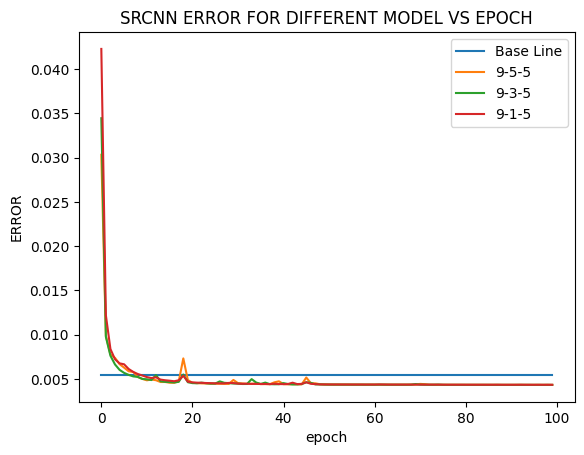

In [ ]:
plotter(allERROR, SRCNNMODELS, "SRCNN ERROR FOR DIFFERENT MODEL", "ERROR")

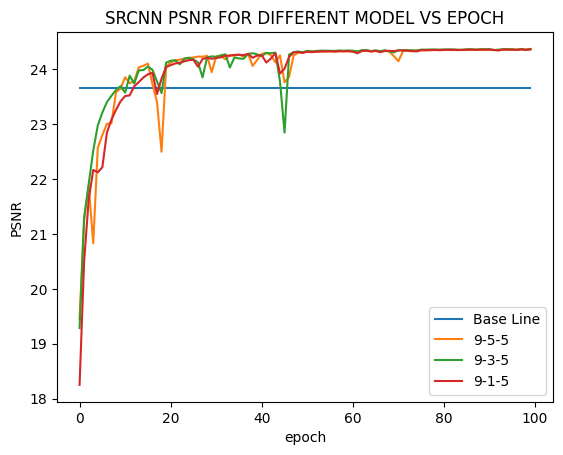

In [ ]:
plotter(allPSNR, SRCNNMODELS, "SRCNN PSNR FOR DIFFERENT MODEL", "PSNR") #Bicubic Method Baseline: avg_train_psnr=23.271748807819048, avg_test_psnr=23.652214591248995, avg_train_ssim=0.6466934772384786, 0.6156241995974027

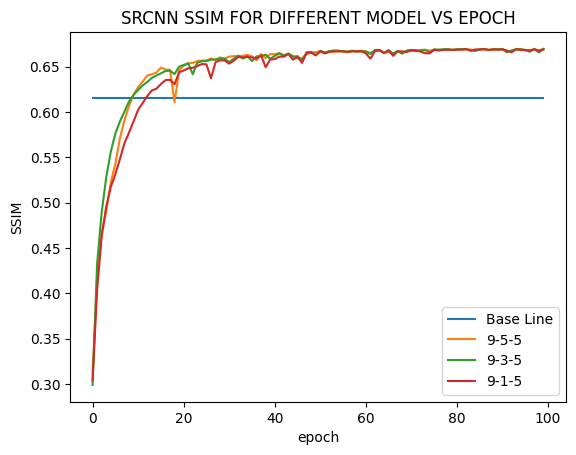

In [ ]:
plotter(allSSIM, SRCNNMODELS, "SRCNN SSIM FOR DIFFERENT MODEL","SSIM")

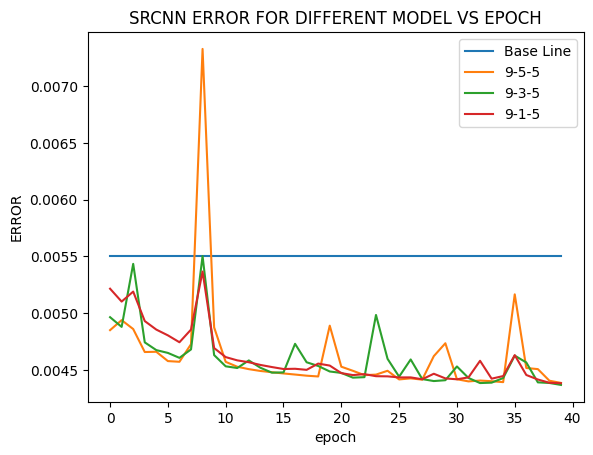

In [ ]:
plotterDetail(allERROR, SRCNNMODELS, "SRCNN ERROR FOR DIFFERENT MODEL", 10, 50, "ERROR")

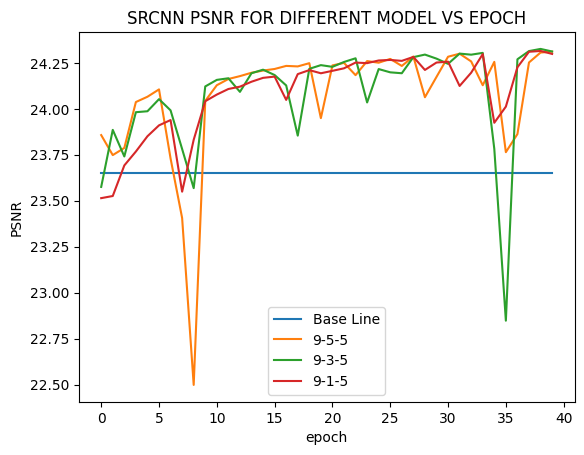

In [ ]:
plotterDetail(allPSNR, SRCNNMODELS, "SRCNN PSNR FOR DIFFERENT MODEL", 10, 50, "PSNR")

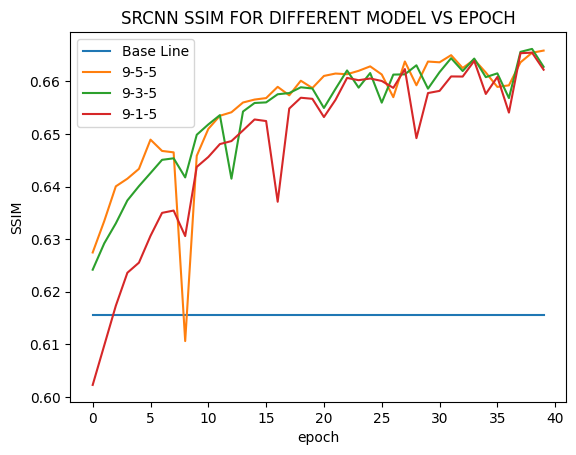

In [ ]:
plotterDetail(allSSIM, SRCNNMODELS, "SRCNN SSIM FOR DIFFERENT MODEL", 10, 50, "SSIM")

## SRCNN PARAMETER TUNE

In [ ]:
batchSize = [4]
upscale = [2,4]
lr = [0.001, 0.0001]

config.changeConfig(2, 100, 0.001, 4)#batchSize,nEpochs,lr,upscale_factor

def SRCNNMain(lr,upscale,batchSize):
  allERROR = {}
  allPSNR = {}
  allSSIM = {}

  for b in batchSize:
    for l in lr:
      for s in upscale:
        config.changeConfig(b, 1, l, s)
        print('===> Loading datasets')
        train_set = get_training_set(config.upscale_factor)
        test_set = get_test_set(config.upscale_factor)
        training_data_loader = DataLoader(dataset=train_set, batch_size=config.batchSize, shuffle=True)
        testing_data_loader = DataLoader(dataset=test_set, batch_size=config.testBatchSize, shuffle=False)
        tempConfig = str(b)+str(l)+str(s)
        print('===> model SRCNN with config', "b = ",b,"lr = ", l,"upscale = ",s)
        modelSRCNN = SRCNNTrainer(config, training_data_loader, testing_data_loader)
        modelSRCNN.run("9-1-5")
        allERROR[tempConfig] = (modelSRCNN.dataForImage)
        allPSNR[tempConfig] = (modelSRCNN.psnrForImage)
        allSSIM[tempConfig] = (modelSRCNN.ssimForImage)

  return allERROR,allPSNR,allSSIM

allERROR,allPSNR,allSSIM = SRCNNMain(lr,upscale,batchSize)



===> Loading datasets
===> model SRCNN with config b =  4 lr =  0.001 upscale =  2
=======>Now running 9-1-5

===> Epoch 1 starts:
 50/50 [================================================================================>]  Step: 266ms | Tot: 15s303ms | Loss: 0.0368
    Average Loss: 0.0368
 100/100 [================================================================================>]  Step: 43ms | Tot: 7s633ms | PSNR: 20.0940
    Average PSNR: 20.0940 dB
Checkpoint saved to model_path.pth
===> Loading datasets
===> model SRCNN with config b =  4 lr =  0.001 upscale =  4
=======>Now running 9-1-5

===> Epoch 1 starts:
 50/50 [================================================================================>]  Step: 122ms | Tot: 9s69ms | Loss: 0.0451
    Average Loss: 0.0451
 100/100 [================================================================================>]  Step: 31ms | Tot: 4s337ms | PSNR: 18.0390
    Average PSNR: 18.0390 dB
Checkpoint saved to model_path.pth
===> Loading dataset

In [ ]:
# allERROR,allPSNR,allSSIM
for i in allERROR.keys():
  print("allERROR,allPSNR,allSSIM :", allERROR[i][-1],allPSNR[i][-1],allSSIM[i][-1])

allERROR,allPSNR,allSSIM : 0.036768254218623043 20.093990595755816 0.4422974281917101
allERROR,allPSNR,allSSIM : 0.045068552158772944 18.038971314610638 0.28921984513689714
allERROR,allPSNR,allSSIM : 0.1130135096423328 17.719380050418675 0.2334550556447445
allERROR,allPSNR,allSSIM : 0.14922499373555184 14.50466553977607 0.11483362567656862
